##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pickle
import efficientnet.tfkeras as efn
from keras.callbacks import EarlyStopping
import keras


### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [ ]:
# (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# # Normalize pixel values to be between 0 and 1
# train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
# # Saving downloaded data for later
# outfile = open("Train Data",'wb')
# pickle.dump((train_images,train_labels),outfile)
# outfile.close()
# outfile = open("Test Data",'wb')
# pickle.dump((test_images,test_labels),outfile)
# outfile.close()

In [2]:
(train_images, train_labels) = pickle.load(open("Train Data",'rb'))
(test_images, test_labels) = pickle.load(open("Test Data",'rb'))

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


Let's display the architecture of your model so far:

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

Here's the complete architecture of your model:

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

### Evaluate the model

In [3]:
# strategy = tf.distribute.MirroredStrategy()
# options = tf.data.Options()
# options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
# dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels,dtype='float64'))
# dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# dataset = dataset.with_options(options).batch(32)

def base_model():
    # with strategy.scope():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    return model
def dropout_model():
    # with strategy.scope():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(.2))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(.3))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10))
    return model
def augment_model():
    # with strategy.scope():
    model = models.Sequential()
    model.add(layers.RandomFlip("horizontal_and_vertical",input_shape=(32,32,3)))
    model.add(layers.RandomRotation(0.1))
    model.add(layers.RandomZoom(0.1))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(.2))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(.3))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(.4))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10))

    return model
def batch_normalize_model():
    # with strategy.scope():
    model = models.Sequential()
    model.add(layers.RandomFlip("horizontal",input_shape=(32,32,3)))
    model.add(layers.RandomRotation(0.1))
    model.add(layers.RandomZoom(0.1))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(.2))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(.2))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(.2))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10))
    return model

def ReshapeLayer(x):
    
    shape = x.shape
    
    # 1 possibility: H,W*channel
    reshape = layers.Reshape((shape[1],shape[2]*shape[3]))(x)
    
    # 2 possibility: W,H*channel
    # transpose = Permute((2,1,3))(x)
    # reshape = Reshape((shape[1],shape[2]*shape[3]))(transpose)
    
    return reshape
def efficient_net():
    # with strategy.scope():
    model = models.Sequential()
    model.add(layers.RandomFlip("horizontal_and_vertical",input_shape=(32,32,3)))
    model.add(layers.RandomRotation(0.1))
    model.add(layers.RandomZoom(0.1))
    model.add(efn.EfficientNetB7(include_top=False,
                pooling='avg'))

    # model.add(layers.Dense(256, activation='selu'))
    model.add(layers.Dense(1024, activation='selu'))

    model.add(layers.BatchNormalization())

    model.add(layers.Dense(10))
    return model
def execute_model(model:models.Sequential, epochs=300):
    model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])    
    history = model.fit(train_images, train_labels, epochs=epochs,
                    validation_data=(test_images, test_labels), callbacks=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()
    _, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
    return test_acc

Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.

Epoch 1/20
1563/1563 [==============================] - 12s 8ms/step - loss: 1.4965 - accuracy: 0.4543 - val_loss: 1.2332 - val_accuracy: 0.5604
Epoch 2/20
1563/1563 [==============================] - 12s 7ms/step - loss: 1.1382 - accuracy: 0.5967 - val_loss: 1.0659 - val_accuracy: 0.6236
Epoch 3/20
1563/1563 [==============================] - 12s 8ms/step - loss: 0.9860 - accuracy: 0.6528 - val_loss: 0.9717 - val_accuracy: 0.6552
Epoch 4/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8957 - accuracy: 0.6849 - val_loss: 0.9284 - val_accuracy: 0.6772
Epoch 5/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8182 - accuracy: 0.7134 - val_loss: 0.8814 - val_accuracy: 0.6935
Epoch 6/20
1563/1563 [==============================] - 12s 7ms/step - loss: 0.7593 - accuracy: 0.7336 - val_loss: 0.8630 - val_accuracy: 0.7059
Epoch 7/20
1563/1563 [==============================] - 12s 7ms/step - loss: 0.7089 - accuracy: 0.7514 - val_loss: 0.8874 - val_ac

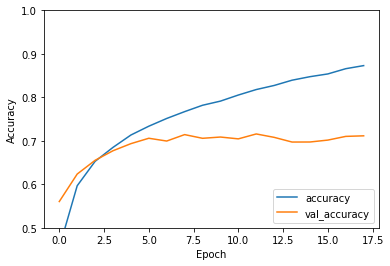

313/313 - 2s - loss: 1.0723 - accuracy: 0.7115 - 2s/epoch - 5ms/step


0.7114999890327454

In [14]:
basemodel = base_model()
execute_model(base_model())

2021-11-17 22:37:53.070192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 22:37:53.070519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 22:37:53.115431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 22:37:53.115831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 22:37:53.116140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Epoch 1/200


2021-11-17 22:37:59.878299: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2021-11-17 22:38:01.509935: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1563/1563 [==============================] - 10s 4ms/step - loss: 1.6954 - accuracy: 0.3727 - val_loss: 1.3552 - val_accuracy: 0.5260
Epoch 2/200
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3772 - accuracy: 0.4997 - val_loss: 1.1713 - val_accuracy: 0.5840
Epoch 3/200
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2568 - accuracy: 0.5503 - val_loss: 1.1218 - val_accuracy: 0.6114
Epoch 4/200
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1917 - accuracy: 0.5724 - val_loss: 1.0454 - val_accuracy: 0.6315
Epoch 5/200
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1368 - accuracy: 0.5933 - val_loss: 1.0342 - val_accuracy: 0.6389
Epoch 6/200
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1011 - accuracy: 0.6083 - val_loss: 1.0043 - val_accuracy: 0.6559
Epoch 7/200
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0724 - accuracy: 0.6188 - val_loss: 1.0275 - val_accuracy: 0.6

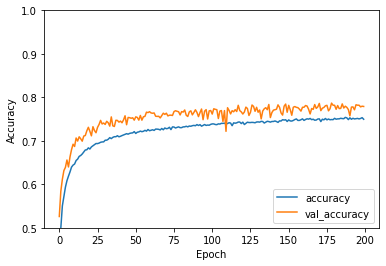

313/313 - 1s - loss: 0.6507 - accuracy: 0.7790 - 612ms/epoch - 2ms/step


0.7789999842643738

In [5]:
dropoutmodel = dropout_model()
execute_model(dropoutmodel)

Epoch 1/300
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8601 - accuracy: 0.2976 - val_loss: 1.5854 - val_accuracy: 0.4229
Epoch 2/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6455 - accuracy: 0.3931 - val_loss: 1.4973 - val_accuracy: 0.4530
Epoch 3/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5803 - accuracy: 0.4220 - val_loss: 1.4181 - val_accuracy: 0.4765
Epoch 4/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5320 - accuracy: 0.4415 - val_loss: 1.3750 - val_accuracy: 0.4956
Epoch 5/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4934 - accuracy: 0.4541 - val_loss: 1.3402 - val_accuracy: 0.5147
Epoch 6/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4690 - accuracy: 0.4644 - val_loss: 1.3722 - val_accuracy: 0.5034
Epoch 7/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4465 - accuracy: 0.4753 - val_loss: 1.3218 - val_a

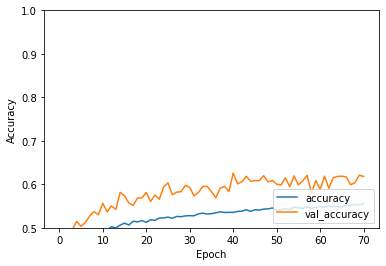

313/313 - 0s - loss: 1.0869 - accuracy: 0.6181 - 481ms/epoch - 2ms/step


0.6180999875068665

In [7]:
augmentmodel = augment_model()
execute_model(augmentmodel)

2021-11-17 23:31:34.222068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 23:31:34.222445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 23:31:34.252250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 23:31:34.252665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 23:31:34.252996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Epoch 1/300


2021-11-17 23:31:41.029855: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2021-11-17 23:31:43.980674: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1563/1563 [==============================] - 39s 22ms/step - loss: 1.6479 - accuracy: 0.4075 - val_loss: 1.4812 - val_accuracy: 0.4753
Epoch 2/300
1563/1563 [==============================] - 32s 21ms/step - loss: 1.3934 - accuracy: 0.4991 - val_loss: 1.3455 - val_accuracy: 0.5318
Epoch 3/300
1563/1563 [==============================] - 31s 20ms/step - loss: 1.2980 - accuracy: 0.5350 - val_loss: 1.1755 - val_accuracy: 0.5747
Epoch 4/300
1563/1563 [==============================] - 32s 20ms/step - loss: 1.2367 - accuracy: 0.5585 - val_loss: 1.0699 - val_accuracy: 0.6204
Epoch 5/300
1563/1563 [==============================] - 31s 20ms/step - loss: 1.1942 - accuracy: 0.5764 - val_loss: 1.0761 - val_accuracy: 0.6173
Epoch 6/300
1563/1563 [==============================] - 32s 20ms/step - loss: 1.1613 - accuracy: 0.5888 - val_loss: 1.0411 - val_accuracy: 0.6404
Epoch 7/300
1563/1563 [==============================] - 32s 20ms/step - loss: 1.1235 - accuracy: 0.6025 - val_loss: 1.0846 - val_

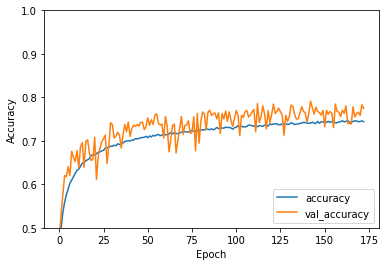

313/313 - 2s - loss: 0.6590 - accuracy: 0.7744 - 2s/epoch - 7ms/step


0.774399995803833

In [4]:
batch_normalizemodel = batch_normalize_model()
execute_model(batch_normalizemodel)

In [4]:
efficient_netmodel = efficient_net()
execute_model(efficient_netmodel)

2021-11-18 06:10:18.357540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:05.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-18 06:10:18.400649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:05.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-18 06:10:18.401421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:05.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-18 06:10:18.402861: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Epoch 1/300


2021-11-18 06:11:08.295067: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2021-11-18 06:11:17.239909: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   7/1563 [..............................] - ETA: 17:13 - loss: 5.3813 - accuracy: 0.1071